# 第6部　機械学習法

## 第2章　ニューラルネットワークと深層学習

### 分析の準備

In [1]:
# Dartsで生成される通知を減らす
import warnings
import logging
# warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# データ読み込みに利用
import statsmodels.api as sm

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# sktime：予測
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error, MeanAbsoluteError,
    mean_absolute_percentage_error, mean_absolute_error
)

# sktime：予測の評価
from sktime.forecasting.model_selection import (
    temporal_train_test_split, ExpandingWindowSplitter, ForecastingGridSearchCV
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データの変換
from sktime.transformations.series.detrend import (
    Deseasonalizer, Detrender
)
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

# sktime：パイプライン
from sktime.forecasting.compose import (
    TransformedTargetForecaster, MultiplexForecaster
)
from sktime.pipeline import make_pipeline
from sktime.transformations.compose import OptionalPassthrough

# 機械学習法
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

# 再帰的に回帰分析を実行するための関数の読み込み
from sktime.forecasting.compose import make_reduction

# Darts関連
from darts import TimeSeries
from darts.models import RNNModel

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

D:\git\020_Books\2022_1_Kodan_python_tsa\030_ブログ用の資料\book-python-tsa-intro\py_tsa_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

### ニューラルネットワーク

#### 活性化関数

Text(0.5, 1.0, 'ReLU')

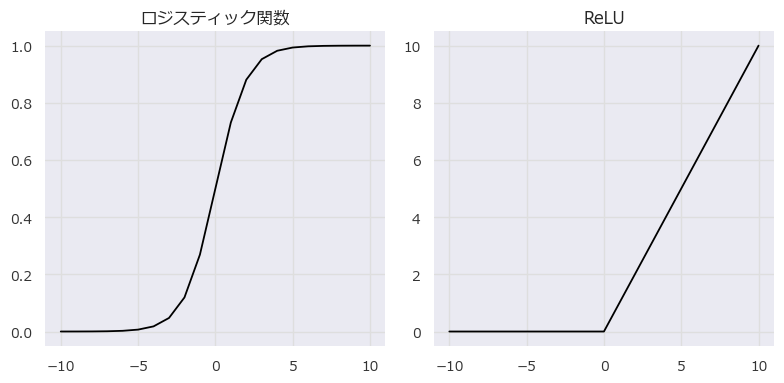

In [3]:
# 教科書の図の作成

# 活性化関数を適用させる対象
x = np.arange(-10, 11)

# ロジスティック関数
def logistic(u):
    return 1 / (1 + np.exp(-u))

# ReLU
def relu(u):
    return np.maximum(0, u)

# 2行のグラフを作る
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, tight_layout=True)

# ロジスティック関数の折れ線グラフ
ax[0].plot(x, logistic(x))
ax[0].set_title('ロジスティック関数')

# ReLUの折れ線グラフ
ax[1].plot(x, relu(x))
ax[1].set_title('ReLU')

### ニューラルネットワークによる飛行機乗客数予測

#### 飛行機乗客数データの読み込み

In [4]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset('AirPassengers').data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(
    start='1949-01', periods=len(air_passengers), freq='M')
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [5]:
# 訓練データとテストデータに分割する
train_air, test_air = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh_air = np.arange(1, len(test_air) + 1)

#### モデルの推定と予測

In [6]:
# 前処理の設定
pipe_transform = make_pipeline(
    Detrender(forecaster=PolynomialTrendForecaster(degree=1), 
              model='multiplicative'),
    TabularToSeriesAdaptor(StandardScaler())
)

In [7]:
# 予測器(ニューラルネットワーク)
nn_regressor = MLPRegressor(hidden_layer_sizes=(100, 100),
                            max_iter=2000, random_state=1)

# 前処理からモデル化までを1つのパイプラインにまとめる
pipe_nn = TransformedTargetForecaster(
    [
        pipe_transform,
        ('forecast', make_reduction(nn_regressor, window_length=12, 
                                    strategy="recursive")),
    ]
)

# データへの当てはめ
pipe_nn.fit(train_air)

TransformedTargetForecaster(steps=[TransformerPipeline(steps=[Detrender(forecaster=PolynomialTrendForecaster(),
                                                                        model='multiplicative'),
                                                              TabularToSeriesAdaptor(transformer=StandardScaler())]),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=2000, random_state=1),
                                                                         window_length=12))])

In [8]:
# 予測の実施
pipe_nn_pred = pipe_nn.predict(fh_air)

# 予測精度
mae = mean_absolute_error(test_air, pipe_nn_pred)
mase = mean_absolute_scaled_error(
    test_air, pipe_nn_pred, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 19.93013422712584
MASE: 0.9809219697803427


### dartsライブラリを利用する準備

In [9]:
# 前処理
transed = pipe_transform.fit_transform(train_air)

# dartsのために日付列を追加
transed['time'] = transed.index.to_timestamp()

# 結果の確認
print(transed.head(3))

            value       time
1949-01  1.005337 1949-01-01
1949-02  1.227182 1949-02-01
1949-03  1.990141 1949-03-01


In [10]:
# dartsのためのデータ
TimeSeries.from_dataframe(
    transed, time_col='time', value_cols='value').head(3)

<TimeSeries (DataArray) (time: 3, component: 1, sample: 1)> Size: 24B
array([[[1.00533693]],

       [[1.22718245]],

       [[1.9901408 ]]])
Coordinates:
  * time       (time) datetime64[ns] 24B 1949-01-01 1949-02-01 1949-03-01
  * component  (component) object 8B 'value'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [11]:
# 参考：データの型
type(TimeSeries.from_dataframe(
    transed, time_col='time', value_cols='value').head(3))

darts.timeseries.TimeSeries

### 深層学習による飛行機乗客数予測

#### RNN

In [12]:
params = {
    'hidden_dim':100,        # 隠れ層のユニットの数
    'n_epochs':300,          # エポックの数
    'random_state':1,        # 乱数の種
    'input_chunk_length':12, # 予測時に渡される過去の時間ステップの数
    'training_length': 24    # 学習時に用いられる訓練データの長さ
}

In [13]:
# モデルの設定
mod_rnn = RNNModel(
    model="RNN",
    **params
)

# 当てはめ
mod_rnn.fit(
    TimeSeries.from_dataframe(transed, time_col='time', value_cols='value'),
    verbose=True
)

Epoch 299: 100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 140.73it/s, train_loss=0.0646]


RNNModel(model=RNN, hidden_dim=100, n_rnn_layers=1, dropout=0.0, training_length=24, n_epochs=300, random_state=1, input_chunk_length=12)

In [14]:
# 予測
rnn_pred = mod_rnn.predict(n=36)

# 整形
rnn_pred = rnn_pred.pd_dataframe()
rnn_pred.index = rnn_pred.index.to_period()

# 変換をもとに戻す
rnn_pred = pipe_transform.inverse_transform(rnn_pred)

# 結果の確認
print(rnn_pred.head(3))

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.09it/s]
component       value
time                 
1958-01    334.855600
1958-02    350.351550
1958-03    396.321065


In [15]:
# 予測精度
mae = mean_absolute_error(test_air, rnn_pred)
mase = mean_absolute_scaled_error(
    test_air, rnn_pred, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 32.707779842394416
MASE: 1.6098125313413996


#### LSTM

In [16]:
# モデルの設定
mod_lstm = RNNModel(
    model="LSTM",
    **params
)

# 当てはめ
mod_lstm.fit(
    TimeSeries.from_dataframe(transed, time_col='time', value_cols='value'),
    verbose=True,
)

Epoch 299: 100%|██████████████████████████████████████████████████████| 3/3 [00:00<00:00, 86.05it/s, train_loss=0.0497]


RNNModel(model=LSTM, hidden_dim=100, n_rnn_layers=1, dropout=0.0, training_length=24, n_epochs=300, random_state=1, input_chunk_length=12)

In [17]:
# 予測
lstm_pred = mod_lstm.predict(n=36)

# 整形
lstm_pred = lstm_pred.pd_dataframe()
lstm_pred.index = lstm_pred.index.to_period()

# 変換をもとに戻す
lstm_pred = pipe_transform.inverse_transform(lstm_pred)

# 結果の確認
print(lstm_pred.head(3))

Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.93it/s]
component       value
time                 
1958-01    344.912153
1958-02    341.386061
1958-03    382.821830


In [18]:
# 予測精度
mae = mean_absolute_error(test_air, lstm_pred)
mase = mean_absolute_scaled_error(
    test_air, lstm_pred, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 16.250495836361843
MASE: 0.7998174123692352


#### 予測結果の比較

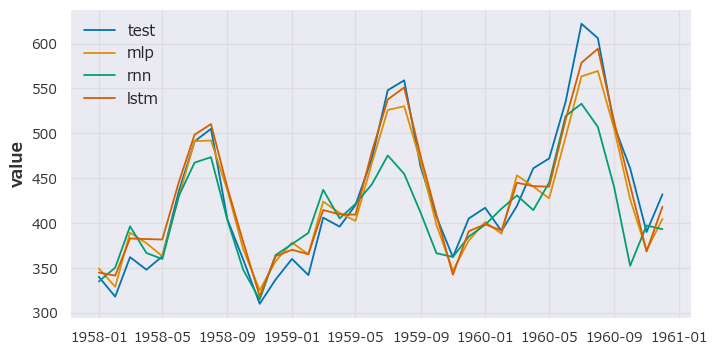

In [19]:
# 予測結果の可視化
fig, ax = plot_series(test_air, pipe_nn_pred, rnn_pred, lstm_pred, 
                      labels=['test', 'mlp', 'rnn', 'lstm'], 
                      markers=np.tile('', 4))
fig.set_size_inches(8, 4)